# Question 1

## (i)
### See Code

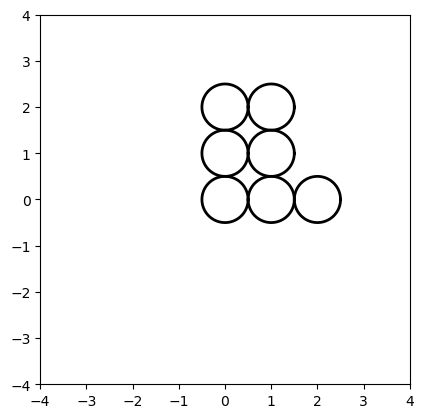

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 94102.61it/s]


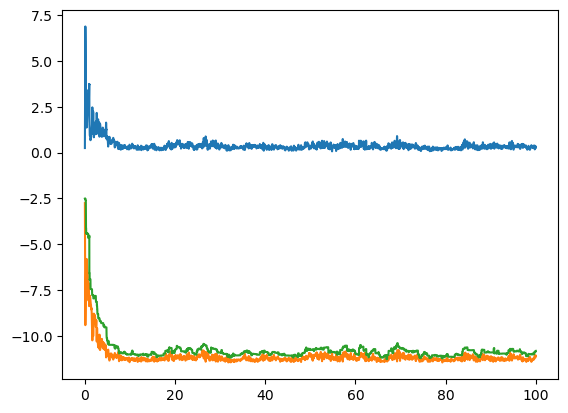

In [2]:
# import packages for basic math, plotting, linear algebra, etc.
from numpy import *
from numpy.linalg import *
from numpy.random import *
from matplotlib.pyplot import *
from scipy.special import binom, erf, erfc
from tqdm import tqdm

class histogram(): # histogram class
    def __init__(self,limits,binwidth):
        self.limits = limits
        self.binwidth = binwidth
        self.vals = arange(self.limits[0] + self.binwidth / 2, self.limits[1], self.binwidth)
        self.histo = 0 * self.vals
        self.N_samples = 0

    def add_sample(self,dat):
        self.N_samples += 1
        if dat > self.limits[0] and dat < self.limits[1]:
            bin_index = int((dat - self.limits[0]) / self.binwidth)
            self.histo[bin_index] += 1

    def normalize(self):
        self.histo = self.histo / (self.N_samples * self.binwidth)

    def barplot(self):
        bar(self.vals, self.histo, width=0.95 * self.binwidth, color='k')
        
    def lineplot(self):
        plot(self.vals, self.histo)

def plot_circle(center,radius): # plot circles
    npoints = 100
    theta = arange(0,2*pi + 1e-7,2*pi/npoints)
    x = center[0] + radius*cos(theta)
    y = center[1] + radius*sin(theta)
    plot(x,y,'k',linewidth=2)

def draw_config(): # draw given configuration
    clf()
    for i in range(N):
        plot_circle(r[i, :], 0.5)
    axis('equal')
    gca().set_adjustable("box")
    view_scale = 4
    xlim(-view_scale, view_scale)
    ylim(-view_scale, view_scale)
    pause(0.01)

def init_config(): # initialize initial condition
    r = zeros((N, 2))
    n_side = int(sqrt(N) + 0.99)
    count = 0
    for row in range(n_side):
        for column in range(n_side):
            if count < N:
                r[count, :] = [row, column]
                count += 1
    return r

N = 7
delta_t = 0.01
total_time = 100
N_steps = int(total_time/delta_t)
T = 0.05
k_coll = 1 # collision rate

r = init_config()
v = zeros((N,2))
draw_config()

from numba import jit
@jit(nopython=True)
def compute_forces_and_potential(r): # compute energy and forces using lj-potential
    forces = zeros((N,2)) 
    potential = 0
    for i in range(N):
        for j in range(i+1,N): # avoid self interaction
            dr = r[i,:] - r[j,:]
            dr2 = dr @ dr
            force_factor = 48 * ( dr2**(-7) - 0.5 * dr2**(-4) ) # force magnitude (analytical derivative of lj potential)
            forces[i,:] += force_factor * dr # force on particle i
            forces[j,:] += force_factor * (-dr) # opposite force on particle j

            potential += 4 * ( dr2**(-6) - dr2**(-3) ) # lj potential

    return forces, potential

forces, potential_energy = compute_forces_and_potential(r)

kinetic_traj = zeros(N_steps)
potential_traj = zeros(N_steps)
for step in tqdm(range(N_steps)): # simulation loop
    v = v + 0.5 * delta_t * forces # half velocity time step
    r = r + delta_t * v # full position time step
    forces, potential_energy = compute_forces_and_potential(r) # compute force and potential
    v = v + 0.5 * delta_t * forces # other velocity half time step

    kinetic_energy = 0.5 * sum( v**2 )
    kinetic_traj[step] = kinetic_energy
    potential_traj[step] = potential_energy

    for i in range(N):
        if rand() < k_coll * delta_t: # metropolis MC condition, k_coll * delta_t = probability of collision given time step
            speed = sqrt(-2 * T * log(rand()) ) # new speed drawn from boltzmann dist
            angle = 2 * pi * rand() # new direction
            v[i,:] = speed * array([cos(angle), sin(angle)]) # assign new random velocity

    # if step % 1000 == 0:
    #     draw_config()

clf()
time_traj = arange(N_steps)*delta_t
plot(time_traj,kinetic_traj)
plot(time_traj,potential_traj)
plot(time_traj,kinetic_traj + potential_traj)


## (ii)
### See Code

In [41]:
N = 16
delta_t = 0.01
total_time = 100
N_steps = int(total_time/delta_t)
T = 0.05
k_coll = 1

density = 0.7
box_length = sqrt(N/density)
r_cut = box_length/2
r_cut_squared = r_cut**2

def init_config(N):
    r = zeros((N, 2))
    n_side = int(sqrt(N) + 0.99)
    count = 0
    for row in range(n_side):
        for column in range(n_side):
            if count < N:
                r[count, :] = [row, column]
                count += 1
    return r

def draw_config(N):
    clf()
    for i in range(N):
        plot_circle(r[i, :], 0.5)
    axis('equal')
    gca().set_adjustable("box")
    view_scale = 4
    xlim(-view_scale, view_scale)
    ylim(-view_scale, view_scale)
    pause(0.01)

r = init_config(N)
v = zeros((N,2))

@jit(nopython=True)
def compute_forces_and_potential(N, r, box_length): 
    forces = np.zeros((N, 2)) 
    potential = 0.0
    for i in range(N):
        for j in range(i+1, N): 
            dr = r[i,:] - r[j,:]
            dr -= box_length * np.floor(dr / box_length + 0.5)
            dr2 = dr @ dr

            if dr2 < r_cut_squared:
                # force_factor = 48 * (dr2**(-7) - 0.5 * dr2**(-4)) - 4 * (r_cut_squared**(-7) - r_cut_squared**(-4))
                force_factor = 48 * (dr2**(-7) - 0.5 * dr2**(-4)) 

                forces[i,:] += force_factor * dr 
                forces[j,:] -= force_factor * dr 

                potential += 4 * (dr2**(-6) - dr2**(-3)) - 4 * (r_cut_squared**(-6) - r_cut_squared**(-3))
    return forces, potential


forces, potential_energy = compute_forces_and_potential(N,r,box_length) # Force and Potential Energy initialization

v = v + 0.5 * delta_t * forces # single time step update
r = r + delta_t * v
forces, potential_energy = compute_forces_and_potential(N,r,box_length)
v = v + 0.5 * delta_t * forces

for i in range(N):
    if rand() < k_coll * delta_t:
        speed = sqrt(-2 * T * log(rand()) )
        angle = 2 * pi * rand()
        v[i,:] = speed * array([cos(angle), sin(angle)])

print(f'U = {potential_energy}')
print(f'F_x = {forces[0]}')

U = -9.472133283012893
F_x = [-22.52238144 -22.52238144]


## (iii)
### See Code

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:35<00:00, 2830.49it/s]


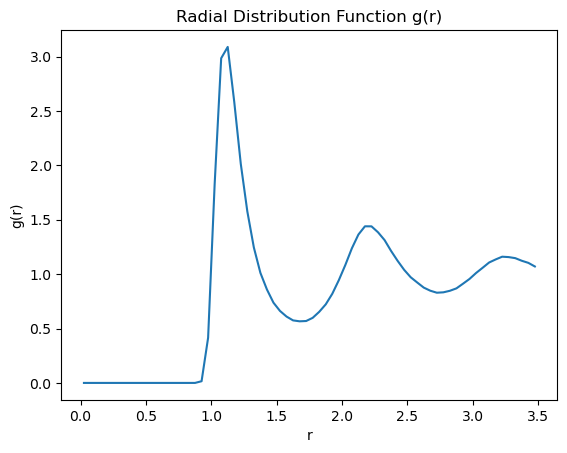

<Figure size 640x480 with 0 Axes>

In [27]:
from tqdm import tqdm

N = 36
delta_t = 0.01
total_time = 1000
N_steps = int(total_time/delta_t)
T = 0.7
k_coll = 1

density = 0.7
box_length = sqrt(N/density)
r_cut = box_length/2
r_cut_squared = r_cut**2

r = init_config(N)
v = zeros((N,2))

binwidth = 0.05
g_r = histogram([0, 3.5], binwidth)
Mconf = 0 

forces, potential_energy = compute_forces_and_potential(N,r,box_length)

kinetic_traj = zeros(N_steps)
potential_traj = zeros(N_steps)
for step in tqdm(range(N_steps)):
    v = v + 0.5 * delta_t * forces 
    r = r + delta_t * v 
    forces, potential_energy = compute_forces_and_potential(N,r,box_length) 
    v = v + 0.5 * delta_t * forces 

    kinetic_energy = 0.5 * sum( v**2 )
    kinetic_traj[step] = kinetic_energy
    potential_traj[step] = potential_energy

    for i in range(N):
        if rand() < k_coll * delta_t:
            speed = sqrt(-2 * T * log(rand()) ) 
            angle = 2 * pi * rand() 
            v[i,:] = speed * array([cos(angle), sin(angle)]) 

    # if step % 1000 == 0:
    #     draw_config()

    if step >= 10000 and step % 10 == 0: # 1000/0.01 = 100000 * 0.1 = 10000
        for i in range(N):
            for j in range(i + 1, N):
                dr_vec = r[i] - r[j]
                dr_vec -= box_length * floor(dr_vec / box_length + 0.5)
                distance = sqrt(dot(dr_vec, dr_vec))
                if distance < 3.5:
                    g_r.add_sample(distance)
        Mconf += 1 


g_r.histo = g_r.histo / (Mconf * pi * g_r.vals * binwidth * (N - 1) * (N / box_length**2))


g_r.lineplot()
xlabel('r')
ylabel('g(r)')
title('Radial Distribution Function g(r)')
show()
savefig('Visualizations/1_iii.png')


It aligns well with previous results. The characteristic oscillations in the particle density is visible. 

In [46]:
len(g_r.histo)

70

# Question 2

## (i)
### See Code

In [42]:
def compute_virial_pressure(N, r, box_length, density):
    p_virial = density
    for i in range(N):
        for j in range(i + 1, N):
            dr = r[i,:] - r[j,:]
            dr -= box_length * floor(dr/box_length + 0.5)
            dr2 = dr @ dr
            if dr2 < r_cut_squared:
                p_virial += (24/box_length**2) * ( dr2**(-6) - 0.5 * dr2**(-3) )

    return p_virial

N = 36
delta_t = 0.01
total_time = 1000
N_steps = int(total_time/delta_t)
T = 0.7
k_coll = 1

density = 0.7
box_length = sqrt(N/density)
r_cut = box_length/2
r_cut_squared = r_cut**2

r = init_config(N)

compute_virial_pressure(N, r, box_length, density)

np.float64(13.180280002043103)

## (ii)

### See Code

In [29]:
from tqdm import tqdm

N = 36
delta_t = 0.01
total_time = 100
N_steps = int(total_time/delta_t)
T = 0.7
k_coll = 1

density = 0.7
box_length = sqrt(N/density)
r_cut = box_length/2
r_cut_squared = r_cut**2

r = init_config(N)
v = zeros((N,2))

forces, potential_energy = compute_forces_and_potential(N,r,box_length)

kinetic_traj = zeros(N_steps)
potential_traj = zeros(N_steps)
p_virials = []

for step in tqdm(range(N_steps)):
    v = v + 0.5 * delta_t * forces 
    r = r + delta_t * v 
    forces, potential_energy = compute_forces_and_potential(N,r,box_length) 
    v = v + 0.5 * delta_t * forces 

    kinetic_energy = 0.5 * sum( v**2 )
    kinetic_traj[step] = kinetic_energy
    potential_traj[step] = potential_energy

    for i in range(N):
        if rand() < k_coll * delta_t:
            speed = sqrt(-2 * T * log(rand()) ) 
            angle = 2 * pi * rand() 
            v[i,:] = speed * array([cos(angle), sin(angle)]) 

    # if step % 1000 == 0:
    #     draw_config()

    if step >= 1000 and step % 10 == 0:
        p_virials.append(compute_virial_pressure(N, r, box_length, density))

print(f'average virial pressure: {np.mean(p_virials)}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3072.18it/s]

average virial pressure: 1.0701850144737148


## (iii)

In [35]:
from tqdm import tqdm

N = 36
delta_t = 0.01
total_time = 100
N_steps = int(total_time/delta_t)
T = 0.7
k_coll = 1

densitys = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
p_virialss = []

for density in densitys:
    box_length = sqrt(N/density)
    r_cut = box_length/2
    r_cut_squared = r_cut**2
    
    r = init_config(N)
    v = zeros((N,2))
    forces, potential_energy = compute_forces_and_potential(N,r,box_length)

    kinetic_traj = zeros(N_steps)
    potential_traj = zeros(N_steps)
    
    p_virials = []
    for step in tqdm(range(N_steps)):
        v = v + 0.5 * delta_t * forces 
        r = r + delta_t * v 
        forces, potential_energy = compute_forces_and_potential(N,r,box_length) 
        v = v + 0.5 * delta_t * forces 
    
        kinetic_energy = 0.5 * sum( v**2 )
        kinetic_traj[step] = kinetic_energy
        potential_traj[step] = potential_energy
    
        for i in range(N):
            if rand() < k_coll * delta_t:
                speed = sqrt(-2 * T * log(rand()) ) 
                angle = 2 * pi * rand() 
                v[i,:] = speed * array([cos(angle), sin(angle)]) 
    
        # if step % 1000 == 0:
        #     draw_config()
    
        if step >= 1000 and step % 10 == 0:
            p_virials.append(compute_virial_pressure(N, r, box_length, density))
    
    p_virialss.append(np.mean(p_virials))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3072.58it/s]


In [36]:
p_virialss

[np.float64(0.08285965268579802),
 np.float64(0.15121404252867898),
 np.float64(0.21181263385466562),
 np.float64(0.27644514312078444),
 np.float64(0.29121007309994695),
 np.float64(0.4990417389889261),
 np.float64(0.9394817902478239),
 np.float64(2.264946207039888)]

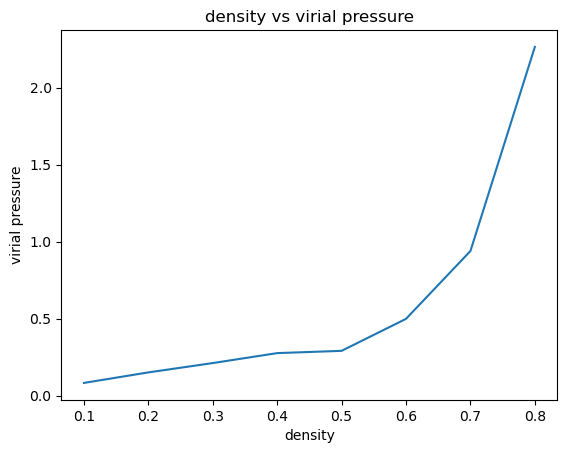

<Figure size 640x480 with 0 Axes>

In [37]:
clf()
plot(densitys,p_virialss)
xlabel('density')
ylabel('virial pressure')
title('density vs virial pressure')
show()
savefig('Visualizations/2_iii.png')

## (iv)

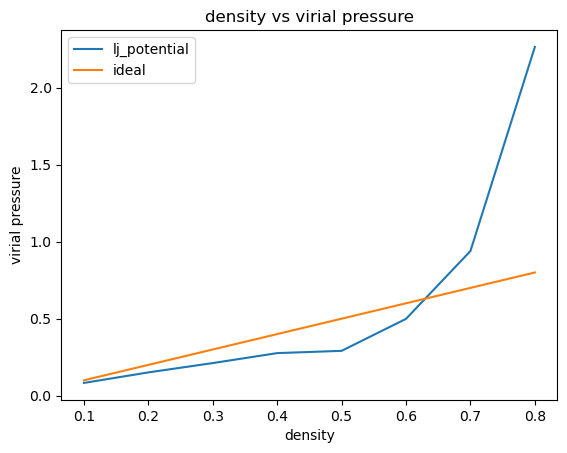

<Figure size 640x480 with 0 Axes>

In [38]:
clf()
time_traj = arange(N_steps - 1000)*delta_t
plot(densitys,p_virialss, label='lj_potential')
plot(densitys, densitys, label='ideal')
xlabel('density')
ylabel('virial pressure')
title('density vs virial pressure')
legend()
show()
savefig('Visualizations/2_iv.png')

The LJ potential is stabilizing by a $r^{-6}$ scale, causing a more attractive force and therefore decreasing the virial pressure. This is stabilization increases as more particles are present. However, after a certain interparticle distance or particle density, the LJ potential becomes destabilizing by a $r^{-12}$ scale, causing an additional repulsive force, increasing the virial pressure. The plot above shows this trend, where lower densities correspond to lower than idea virial pressures while very high densities correspond diverging virial pressure. 

## (v)

### See Code

In [43]:
from tqdm import tqdm

N = 36
delta_t = 0.01
total_time = 100
N_steps = int(total_time/delta_t)
T = 0.7
k_coll = 1

densitys = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
p_virialss = []

for density in densitys:
    box_length = sqrt(N/density)
    r_cut = 2**(1/6)
    r_cut_squared = r_cut**2
    
    r = init_config(N)
    v = zeros((N,2))
    forces, potential_energy = compute_forces_and_potential(N,r,box_length)

    kinetic_traj = zeros(N_steps)
    potential_traj = zeros(N_steps)
    
    p_virials = []
    for step in tqdm(range(N_steps)):
        v = v + 0.5 * delta_t * forces 
        r = r + delta_t * v 
        forces, potential_energy = compute_forces_and_potential(N,r,box_length) 
        v = v + 0.5 * delta_t * forces 
    
        kinetic_energy = 0.5 * sum( v**2 )
        kinetic_traj[step] = kinetic_energy
        potential_traj[step] = potential_energy
    
        for i in range(N):
            if rand() < k_coll * delta_t:
                speed = sqrt(-2 * T * log(rand()) ) 
                angle = 2 * pi * rand() 
                v[i,:] = speed * array([cos(angle), sin(angle)]) 
    
        # if step % 1000 == 0:
        #     draw_config()
    
        if step >= 1000 and step % 10 == 0:
            p_virials.append(compute_virial_pressure(N, r, box_length, density))
    
    p_virialss.append(np.mean(p_virials))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3214.09it/s]


## (vi)

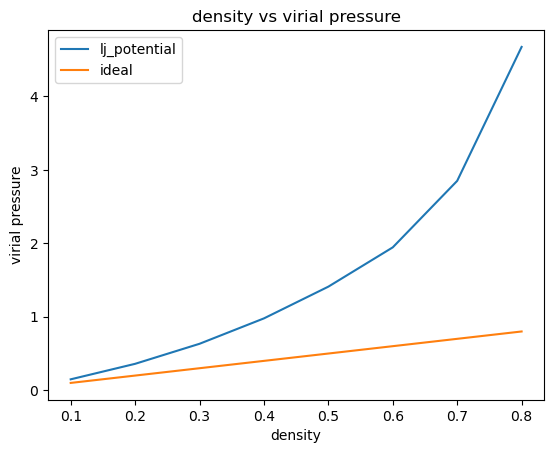

<Figure size 640x480 with 0 Axes>

In [44]:
clf()
time_traj = arange(N_steps - 1000)*delta_t
plot(densitys,p_virialss, label='lj_potential')
plot(densitys, densitys, label='ideal')
xlabel('density')
ylabel('virial pressure')
title('density vs virial pressure')
legend()
show()
savefig('Visualizations/2_v.png')

With a smaller cutoff radius, the stabalizing energy is removed and only the destabilizing portion remains. Without the stabalizing interaction energy, the new virial pressure resembles the ideal gas at smaller densities, but should diverge more significantly at higher densities. 